# Age Estimation and Gender Classification

In this project, I solved two tasks: given a photo, estimate age and gender of a person. Two different neural networks have been created and trained - the first by scratch, and the second via fine-tuning. Both neural networks have branch-like structure, which means that they can run training and inference for both tasks simultaneously.

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import callbacks, losses, metrics, models, optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.utils import plot_model, Sequence

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data visualization

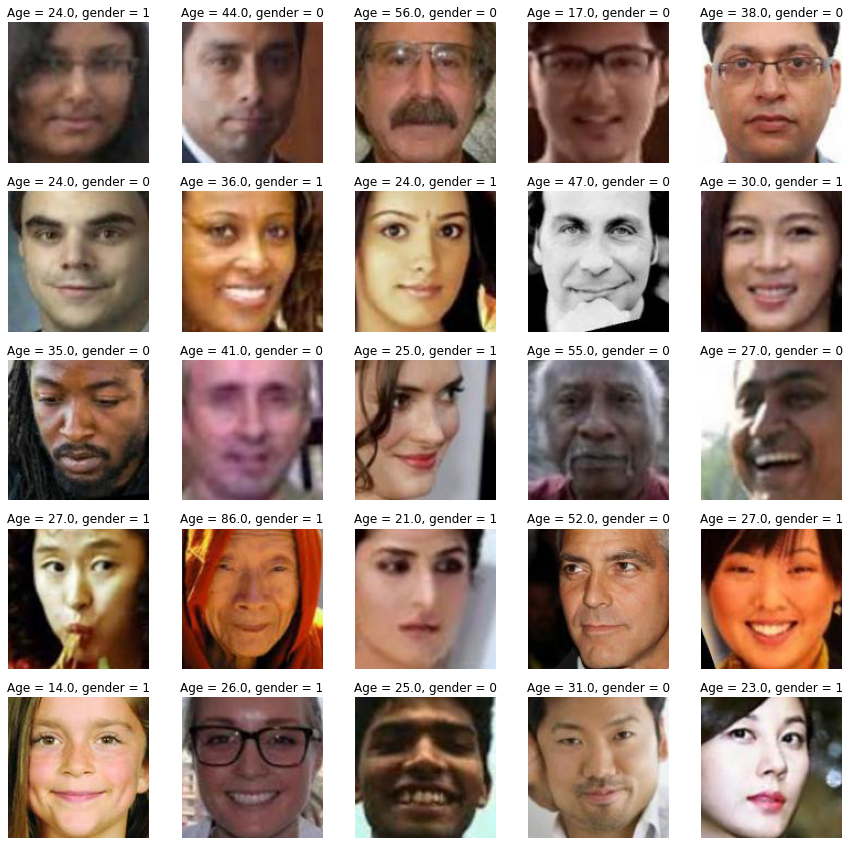

In [ ]:
# a function to extract age and gender from file_name
# e.g.: input '[age]_[gender]_[race]_[date&time].jpg' -> output [age], [gender]
def extract_target(file_name):
    age, gender = file_name.split('_')[:2]
    age, gender = float(age), int(gender)
    return age, gender


# let us plot 25 random images from the dataset

IMG_DIR = '/content/drive/MyDrive/age_gender_estimation/train_val'
random_img_files = np.random.choice(os.listdir(IMG_DIR), 25)

# also store image shapes in order to check them
img_sizes = []

plt.figure(figsize=(15, 15))
for i, file_name in enumerate(random_img_files, start=1):
    age, gender = extract_target(file_name)
    plt.subplot(5, 5, i)
    img = plt.imread(os.path.join(IMG_DIR, file_name))
    img_sizes.append(img.shape)
    plt.imshow(img)
    plt.title(f'Age = {age}, gender = {gender}')
    plt.axis('off')

Let us print sizes of all random images that we extracted:

In [ ]:
print(img_sizes)

[(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]


We can see that all sizes are the same - (128, 128, 3).

## Train/test split

Here, we split files in image directory into training and validation data in 3:1 ratio. On the next step, we will create custom data generators from the obtained lists of image file names.

In [ ]:
train_img_names, val_img_names = train_test_split(os.listdir(IMG_DIR), test_size=0.25, random_state=42, shuffle=True)
print(f'Number of images in train: {len(train_img_names)}')
print(f'Number of images in val: {len(val_img_names)}')

Number of images in train: 3750
Number of images in val: 1250


## Data preprocessing

In order to correctly feed the data into the neural network later and construct data processing pipeline in the same time, custom data generator class is created. Necessary methods are specified:

*   `__init__` - initialize parameters
*   `__getitem__` - how to process images and create a batch from them
*   `__len__` - what is the length of the data sequence
*   `on_epoch_end` - what happens after the epoch end (the data is shuffled)

`__getitem__` step is the most complicated one. There, we choose images to put in a batch. Then, for each image, we open it, transform with augmentations (if we are on a training step), extract age and gender. Finally, we output a formed batch: images and the corresponding correct answers (age and gender).

For augmentations, transformations from `albumentations` library has been used: https://albumentations.ai

We also fix batch size - 128. This batch size seems neither too big (for the dataset with 5000 images total) nor too small (so that the training is smooth).

In [ ]:
BATCH_SIZE = 128


class DataGenerator(Sequence):
    def __init__(self, img_names, transforms=None, batch_size=BATCH_SIZE, img_dir=IMG_DIR):
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_names = img_names
        self.indices = np.arange(len(self.img_names))   # indices are used in order to correctly grab images to form batches
        self.transforms = transforms

    def __getitem__(self, idx):
        # for batch #idx, we choose image files with indices from idx * self.batch_size to (idx + 1) * self.batch_size - 1 (last point of slice is excluded)
        # e.g. for batch 0, we choose image files with indices 0-127
        #      for batch 1, we choose image files with indices 128-255
        #.     for batch 2, we choose image files with indices 256-383, etc.
        batch_indices = self.indices[(idx * self.batch_size):((idx + 1) * self.batch_size)]
        
        batch = {'img': [], 'age': [], 'gender': []}
        
        for i in batch_indices:
            # choose image file with the corresponding index, open it and obtain an image
            img_name = self.img_names[i]
            img = np.array(Image.open(os.path.join(self.img_dir, img_name)))
            
            # if there are some transforms - apply them
            if self.transforms is not None:
                img = self.transforms(image=img)['image']
            
            age, gender = extract_target(img_name)
            
            # do not forget to scale the image to convert its pixels range from 0-255 to 0-1
            batch['img'].append(img / 255), batch['age'].append(age), batch['gender'].append(gender)

        return np.array(batch['img']), (np.array(batch['age']), np.array(batch['gender']))

    def __len__(self):
        return len(self.img_names) // self.batch_size

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


# some transforms which do not corrupt images too much, but provide some flexible data augmentation
# transforms have been chosen with the help of the parrot on the front page: https://github.com/albumentations-team/albumentations/blob/master/README.md
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.JpegCompression(quality_lower=90, quality_upper=100, p=0.5)
])

# we apply data transforms only on the training step, not on validation step
train_datagenerator = DataGenerator(train_img_names, transforms=transforms_train)
val_datagenerator = DataGenerator(val_img_names)

Let's verify the work we have done so far and print 25 images from the example batch.

Image shape in a batch: (128, 128, 128, 3)
Target shape in a batch: (128,) - age, (128,) - gender
Image pixel values in a batch: min 0.0, max 1.0



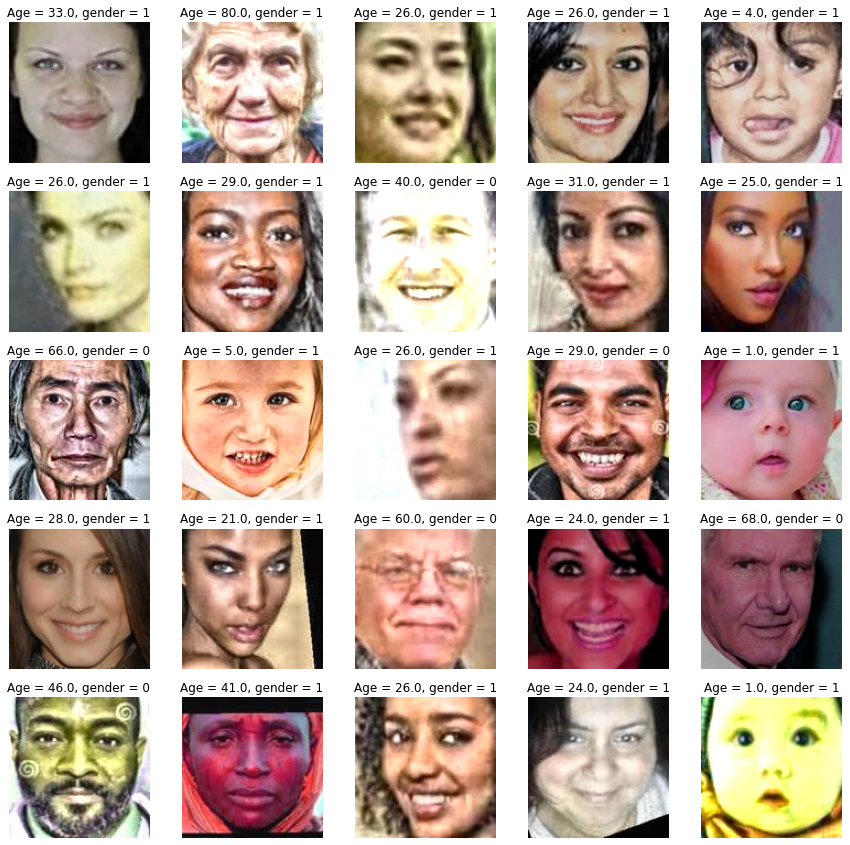

In [ ]:
batch_img, (batch_age, batch_gender) = train_datagenerator[0]
print(f'Image shape in a batch: {batch_img.shape}')
print(f'Target shape in a batch: {batch_age.shape} - age, {batch_gender.shape} - gender')
print(f'Image pixel values in a batch: min {batch_img.min()}, max {batch_img.max()}\n')

plt.figure(figsize=(15, 15))
for i, img in enumerate(batch_img[:25]):
    age, gender = batch_age[i], batch_gender[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Age = {age}, gender = {gender}')
    plt.axis('off')

We can see that:

*   images are loaded correctly;
*   code for data augmentation works;
*   batch shape is correct;
*   batch includes target values of correct shapes;
*   images are scaled so that the pixels have a range 0-1

Everything is OK, we can move to the next step.

## CNN A: custom architecture

The neural network which is constructed consists of a block with the following combination of layers: Conv2D -> ReLU -> BatchNorm -> MaxPool2D. This combination repeats 4 times. Convolutional layer has an argument `padding='same'`, which means that it does not change the height and width of the feature map. At the beginning, we have image of shape (128, 128, 3) - its depth is much smaller than height and width. Finally, we obtain feature map of shape (8, 8, 512) - its depth is much larger than height and width. Alternating convolutional and pooling layers, we end up with a useful information extracted from the image.

In the end of the block, there is a GlobalAveragePooling layer which is used to average values in each channel and obtain only one value per channel (https://paperswithcode.com/method/global-average-pooling). This is an alternative to simply flattening the feature map before fully connected layers.

After the main block, there are two different branches - "age" and "gender". The purpose of each branch is to solve its own separate task. We distinguish two branches to learn the parameters for two different tasks separately. This technique does not let the branches interfere each other and thus improves the results.

The branches are constructed in a similar way. In each branch, there are two fully connected layers with ReLU and dropout between them. They help to process information from the main block separately for each task and extract new useful features. Finally, there is a solving fully connected layer with one neuron in the end. In case of age estimation, there is no final activation function, because we output a real value. However, when we estimate gender class, we use sigmoid activation function to convert real-valued logits to probabilities from 0 to 1.

Model: "modelA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 main_block (Sequential)        (None, 512)          1554816     ['inputs[0][0]']                 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1 (Conv2D)               (None, 128, 128, 64  1792        []                               |
|                              )                                                                 |
|                                                                                            

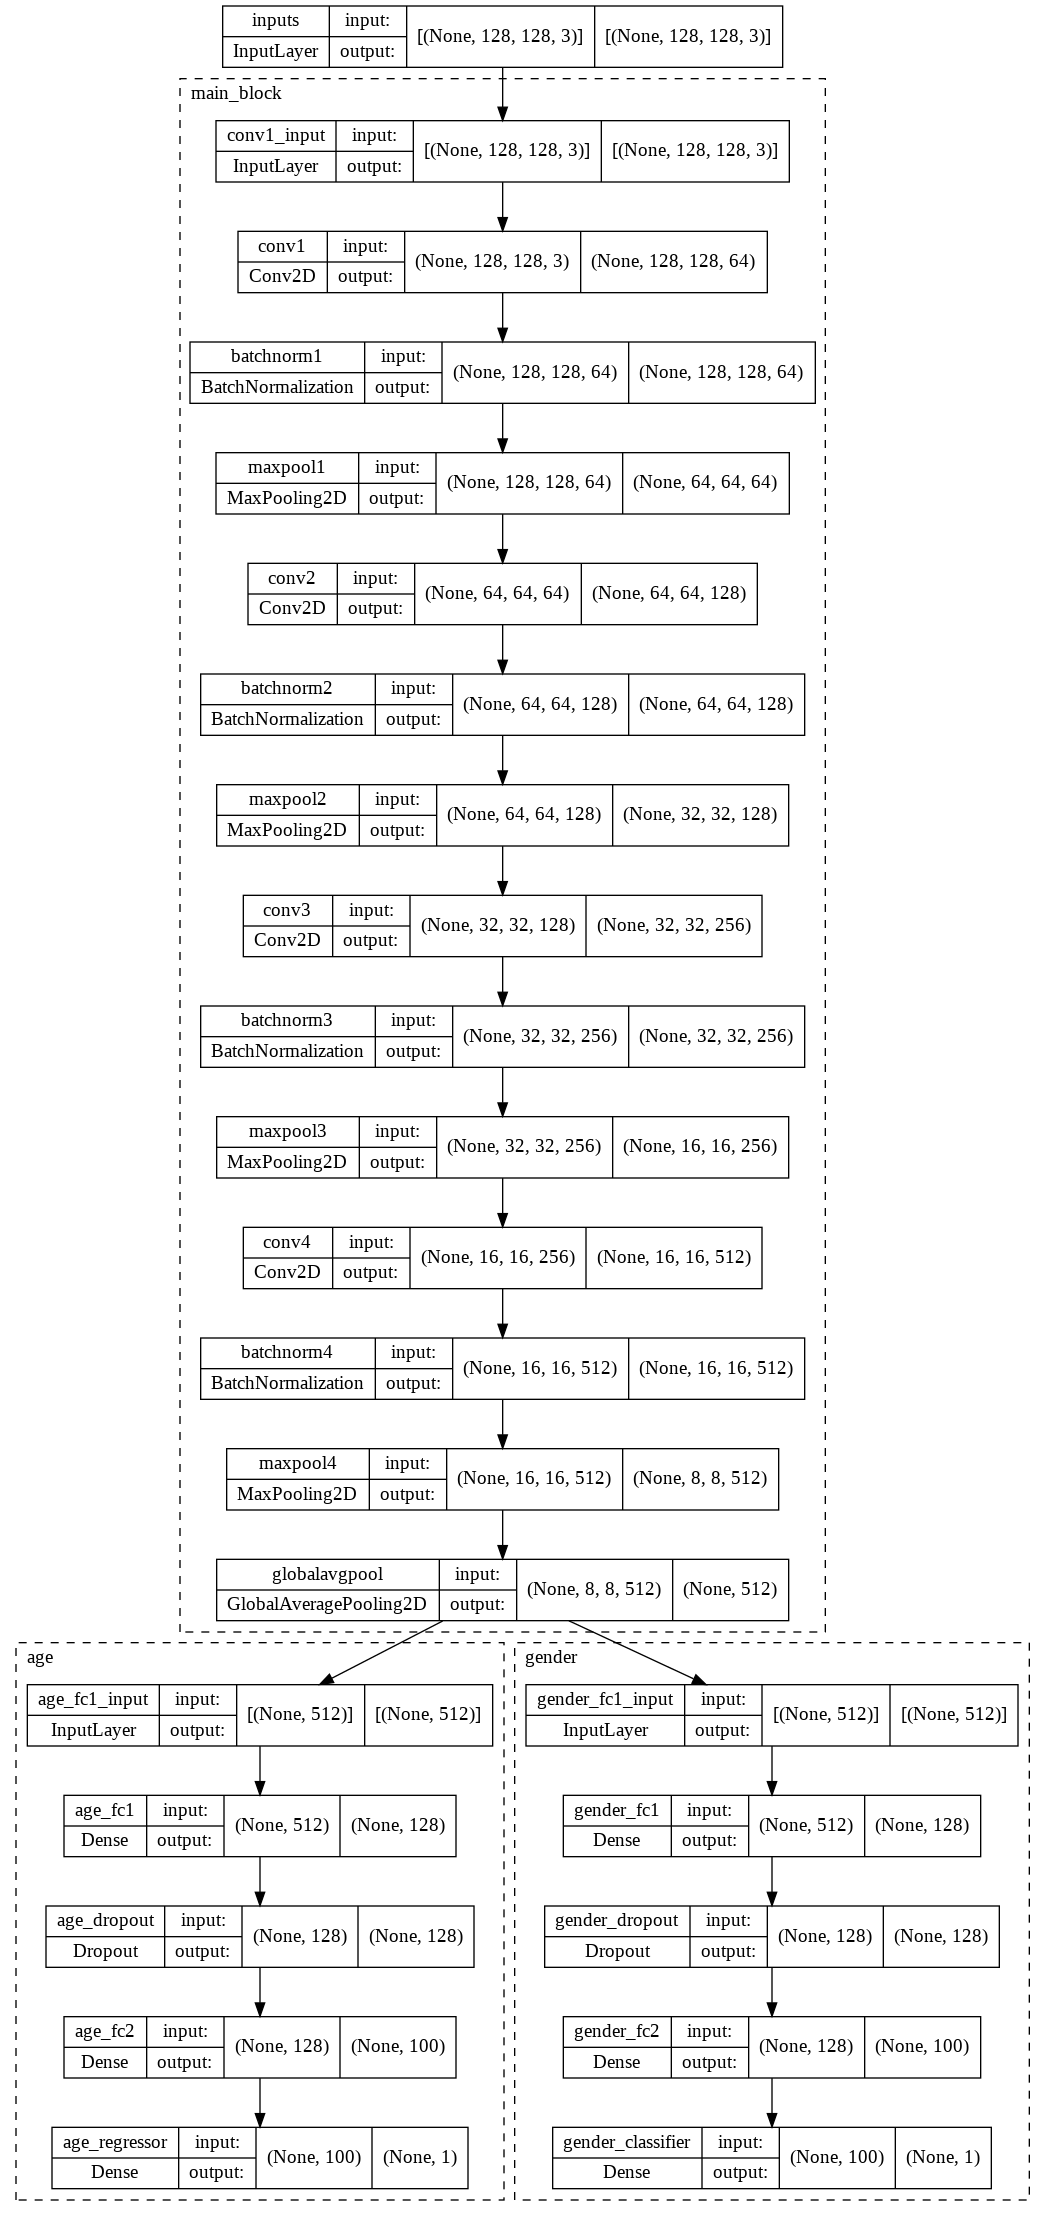

In [ ]:
def create_model(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape, name='inputs')

    # main block
    main_block = keras.Sequential([
        Conv2D(64, 3, padding='same', activation='relu', name='conv1'),
        BatchNormalization(name='batchnorm1'),
        MaxPooling2D(name='maxpool1'),
        Conv2D(128, 3, padding='same', activation='relu', name='conv2'),
        BatchNormalization(name='batchnorm2'),
        MaxPooling2D(name='maxpool2'),
        Conv2D(256, 3, padding='same', activation='relu', name='conv3'),
        BatchNormalization(name='batchnorm3'),
        MaxPooling2D(name='maxpool3'),
        Conv2D(512, 3, padding='same', activation='relu', name='conv4'),
        BatchNormalization(name='batchnorm4'),
        MaxPooling2D(name='maxpool4'),
        GlobalAveragePooling2D(name='globalavgpool')
    ], name='main_block')
    main_block_outputs = main_block(inputs)

    # branch 1: age head
    branch_age = keras.Sequential([
        Dense(128, activation='relu', name='age_fc1'),
        Dropout(rate=0.4, name='age_dropout'),
        Dense(100, activation='relu', name='age_fc2'),
        Dense(1, name='age_regressor')
    ], name='age')
    branch_age_outputs = branch_age(main_block_outputs)

    # branch 2: gender head
    branch_gender = keras.Sequential([
        Dense(128, activation='relu', name='gender_fc1'),
        Dropout(rate=0.4, name='gender_dropout'),
        Dense(100, activation='relu', name='gender_fc2'),
        Dense(1, activation='sigmoid', name='gender_classifier')
    ], name='gender')
    branch_gender_outputs = branch_gender(main_block_outputs)

    return keras.Model(inputs=inputs, outputs=[branch_age_outputs, branch_gender_outputs], name='modelA')


modelA = create_model()
# expand model architecture to show all layers
modelA.summary(expand_nested=True)
plot_model(modelA, show_shapes=True, expand_nested=True, show_layer_activations=True)

## CNN A: training from scratch

After we have built the neural network model, we can train it. As an optimizer, Adam with learning rate 0.004 is used. Two different loss functions are used: MAE for age estimation and binary cross-entropy for gender estimation. Similarly, two different metrics are used: MAE for age estimation and binary accuracy for gender estimation.

Model is trained using training and validation custom data generator which have been created previously. The number of epochs to train the model is set to 300; however, it is just an upper bound, and as we can see further, the actual number of epochs used to train the model is much smaller.

In order to prevent overfitting, several callbacks are used. First of all, we use early stopping. If for 30 epochs there are no improvements in validation loss, we stop the training and save model weights corresponding to the best validation loss value.

Secondly, if validation loss does not improve for 15 epochs, we multiply learning rate by 0.2. The motivation for this is that if we have too large learning rate, we can take too big steps during gradient descent and "jump" around correct loss function minimization direction. If the neural network is stuck, we might help it to learn better by decreasing learning rate to make smaller steps.

In [ ]:
%%time

EPOCHS = 300

your_model_folder = '/content/drive/MyDrive/age_gender_estimation/models/'

modelA.compile(
    optimizer=optimizers.Adam(learning_rate=4e-3),
    loss={
        'age': losses.MeanAbsoluteError(),
        'gender': losses.BinaryCrossentropy()
    },
    metrics={
        'age': metrics.MeanAbsoluteError(),
        'gender': metrics.BinaryAccuracy()
    }
)

history_modelA = modelA.fit(
    x=train_datagenerator,
    validation_data=val_datagenerator,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, factor=0.2, min_lr=1e-7)
    ]
)

modelA.save_model(your_model_folder+"age_gender_A.h5")

Epoch 1/300
29/29 [==============================] - 36s 1s/step - loss: 18.3982 - age_loss: 17.6223 - gender_loss: 0.7759 - age_mean_absolute_error: 17.6223 - gender_binary_accuracy: 0.5342 - val_loss: 92.6237 - val_age_loss: 91.5371 - val_gender_loss: 1.0866 - val_age_mean_absolute_error: 91.5371 - val_gender_binary_accuracy: 0.4627 - lr: 0.0040
Epoch 2/300
29/29 [==============================] - 22s 768ms/step - loss: 15.4473 - age_loss: 14.7541 - gender_loss: 0.6932 - age_mean_absolute_error: 14.7541 - gender_binary_accuracy: 0.5741 - val_loss: 33.5377 - val_age_loss: 32.8118 - val_gender_loss: 0.7259 - val_age_mean_absolute_error: 32.8118 - val_gender_binary_accuracy: 0.5321 - lr: 0.0040
Epoch 3/300
29/29 [==============================] - 25s 857ms/step - loss: 15.0813 - age_loss: 14.4222 - gender_loss: 0.6591 - age_mean_absolute_error: 14.4222 - gender_binary_accuracy: 0.6096 - val_loss: 19.9029 - val_age_loss: 19.1470 - val_gender_loss: 0.7559 - val_age_mean_absolute_error: 19

## CNN A: plotting learning curves

In order to draw figures, we use history saved during model training. This history contains loss and metric values on each step.

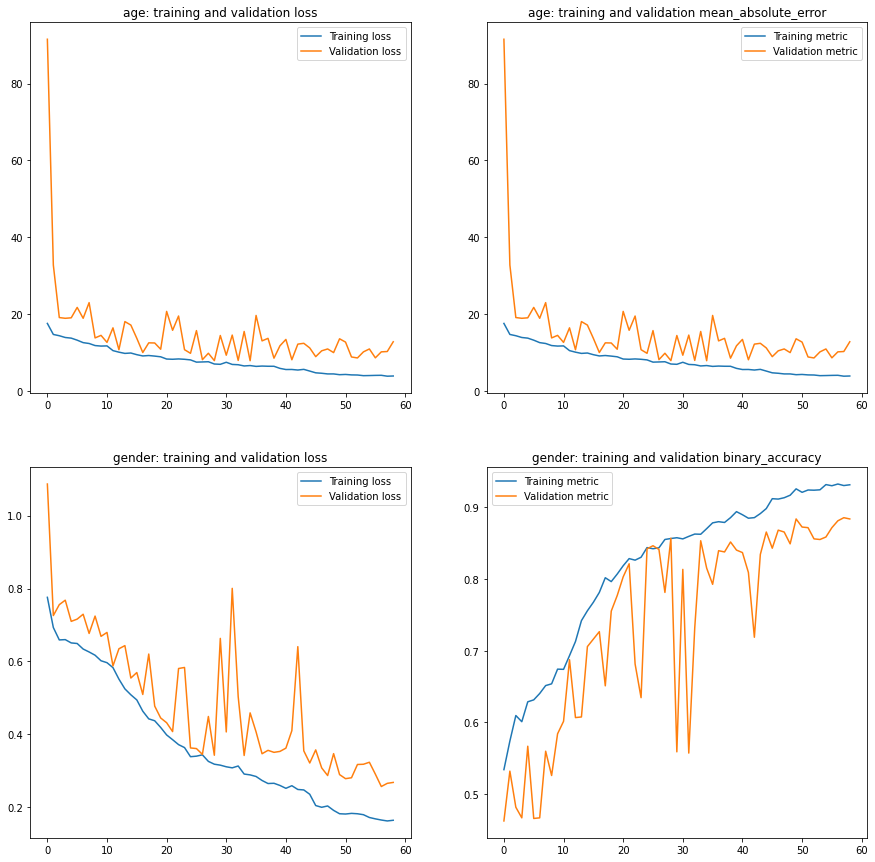

In [ ]:
def draw_learning_curve_loss(history, branch_name):
    train_loss = history.history[f'{branch_name}_loss']
    val_loss = history.history[f'val_{branch_name}_loss']

    plt.title(f'{branch_name}: training and validation loss')
    plt.plot(range(len(train_loss)), train_loss, label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation loss')
    plt.legend(loc='best')


def draw_learning_curve_metric(history, branch_name, metric_name):
    train_loss = history.history[f'{branch_name}_{metric_name}']
    val_loss = history.history[f'val_{branch_name}_{metric_name}']

    plt.title(f'{branch_name}: training and validation {metric_name}')
    plt.plot(range(len(train_loss)), train_loss, label='Training metric')
    plt.plot(range(len(val_loss)), val_loss, label='Validation metric')
    plt.legend(loc='best')


plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
draw_learning_curve_loss(history_modelA, 'age')

plt.subplot(2, 2, 2)
draw_learning_curve_metric(history_modelA, 'age', 'mean_absolute_error')

plt.subplot(2, 2, 3)
draw_learning_curve_loss(history_modelA, 'gender')

plt.subplot(2, 2, 4)
draw_learning_curve_metric(history_modelA, 'gender', 'binary_accuracy')

plt.show()

As we can see, learning curves are rather oscillating. Learning process can probably be improved by:

*   modifying neural network architecture (e.g. changing number of convolutional layers, number of filters in them);
*   modifying training procedures (e.g. changing learning rate)

Nevertheless, the neural network is able to learn and obtain satisfactory quality in both tasks.

## CNN B: VGG16-based architecture

In the main block, we used pretrained VGG16 neural network. On top of it, we add dropout and fully connected layers in order to process the information coming from VGG16.

After this, similar strategy with branches is used as in the model A. 

Model: "modelB"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          14780352    ['inputs[0][0]']                 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| vgg16 (Functional)           (None, 512)          14714688    []                               |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| input_2 (InputLayer)       [(None, 128, 128, 3  0           []                            

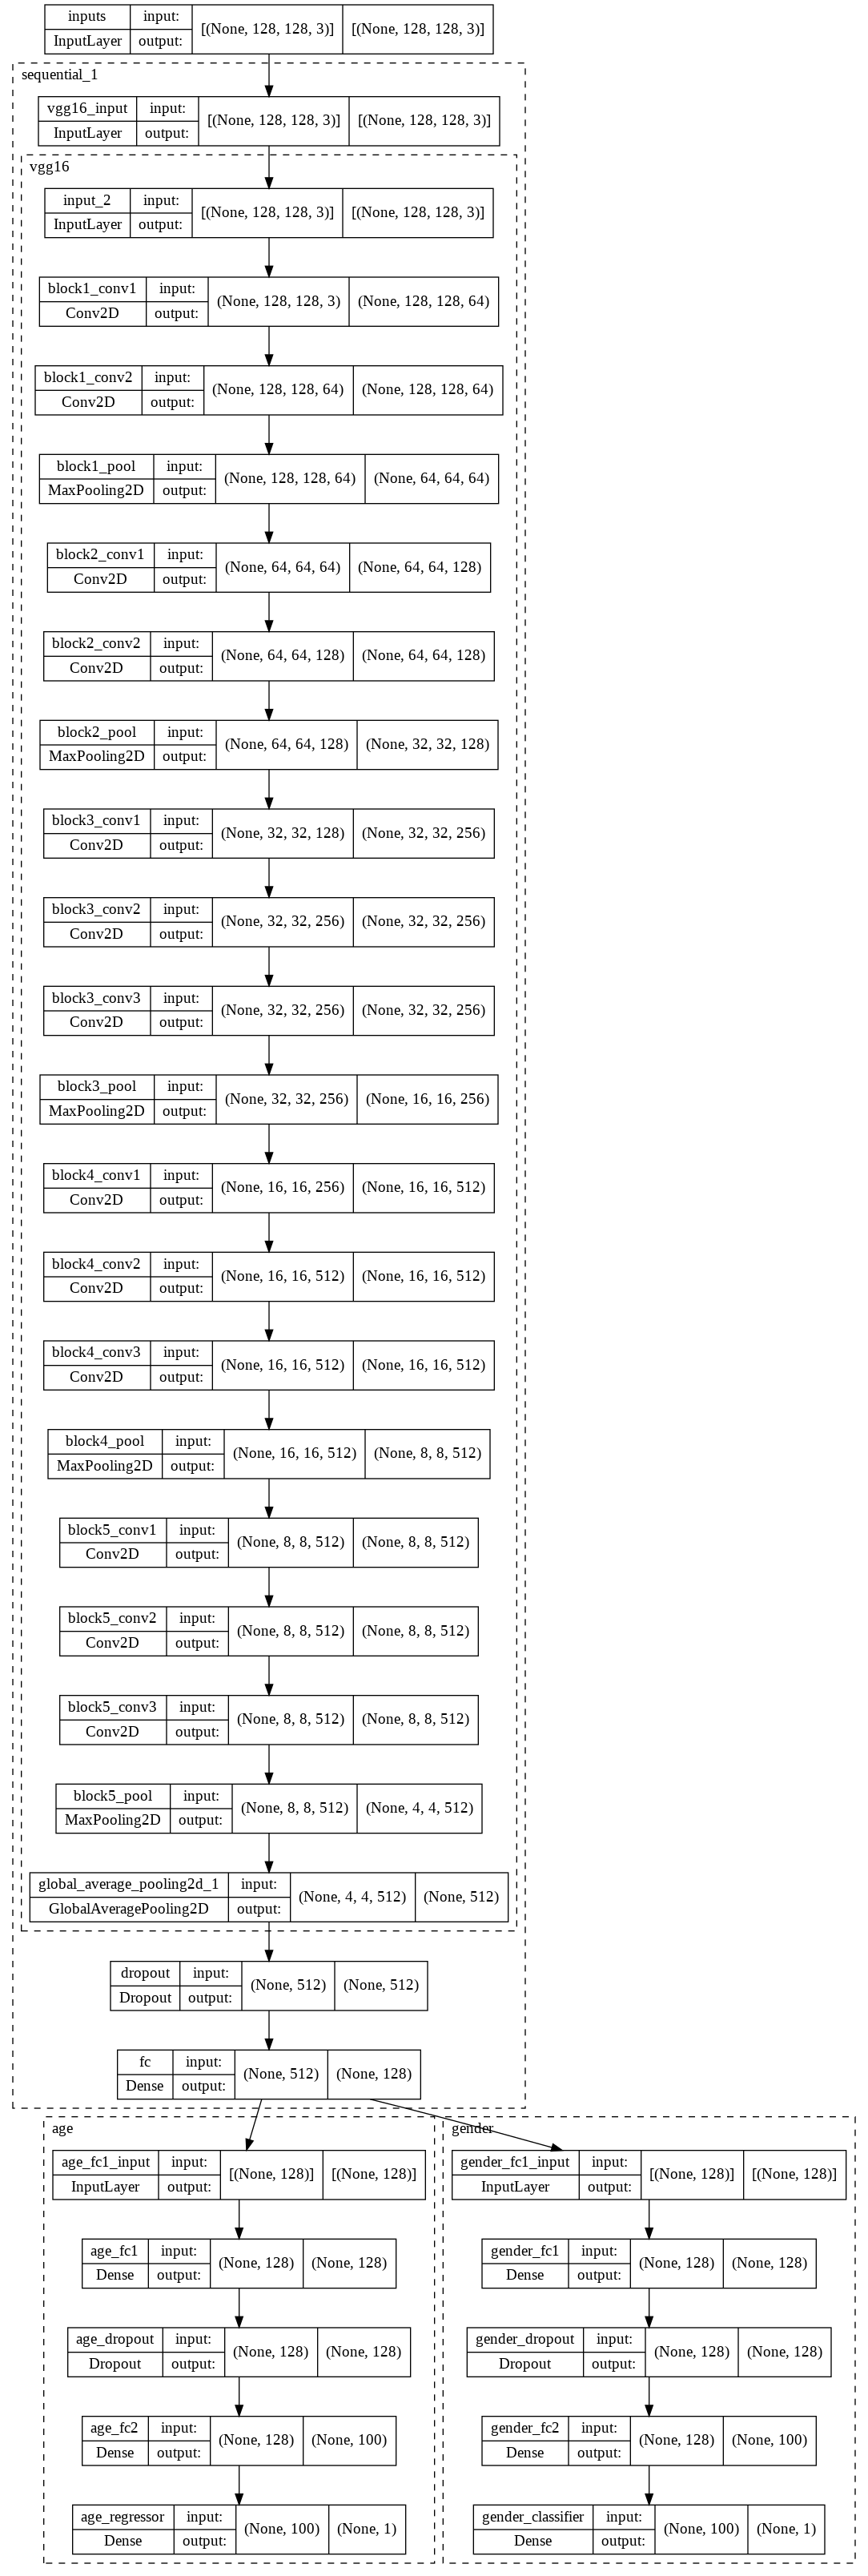

In [ ]:
def create_model(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape, name='inputs')

    # main block
    main_block = keras.Sequential([
        VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg'),
        Dropout(rate=0.4, name='dropout'),
        Dense(128, activation='relu', name='fc')
    ])
    main_block_outputs = main_block(inputs)

    # branch 1: age head
    branch_age = keras.Sequential([
        Dense(128, activation='relu', name='age_fc1'),
        Dropout(rate=0.4, name='age_dropout'),
        Dense(100, activation='relu', name='age_fc2'),
        Dense(1, name='age_regressor')
    ], name='age')
    branch_age_outputs = branch_age(main_block_outputs)

    # branch 2: gender head
    branch_gender = keras.Sequential([
        Dense(128, activation='relu', name='gender_fc1'),
        Dropout(rate=0.4, name='gender_dropout'),
        Dense(100, activation='relu', name='gender_fc2'),
        Dense(1, activation='sigmoid', name='gender_classifier')
    ], name='gender')
    branch_gender_outputs = branch_gender(main_block_outputs)

    return keras.Model(inputs=inputs, outputs=[branch_age_outputs, branch_gender_outputs], name='modelB')


modelB = create_model()
# expand model architecture to show all layers
modelB.summary(expand_nested=True)
plot_model(modelB, show_shapes=True, expand_nested=True, show_layer_activations=True)

## CNN B: fine-tuning

Training procedure is similar to the training procedure for the modelA, except starting learning rate in optimizer. Here, it is changed to 0.0001. We set it to a smaller value in comparison with modelA because we want to behave with pretrained weights in a more smooth manner.

In [ ]:
%%time

EPOCHS = 300

your_model_folder = '/content/drive/MyDrive/age_gender_estimation/models/'

modelB.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss={
        'age': losses.MeanAbsoluteError(),
        'gender': losses.BinaryCrossentropy()
    },
    metrics={
        'age': metrics.MeanAbsoluteError(),
        'gender': metrics.BinaryAccuracy()
    }
)

history_modelB = modelB.fit(
    x=train_datagenerator,
    validation_data=val_datagenerator,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, factor=0.2, min_lr=1e-7)
    ]
)

modelB.save_model(your_model_folder+"age_gender_B.h5")

Epoch 1/300
29/29 [==============================] - 44s 1s/step - loss: 20.6803 - age_loss: 18.8673 - gender_loss: 1.8130 - age_mean_absolute_error: 18.8673 - gender_binary_accuracy: 0.4952 - val_loss: 14.7120 - val_age_loss: 13.7532 - val_gender_loss: 0.9588 - val_age_mean_absolute_error: 13.7532 - val_gender_binary_accuracy: 0.5304 - lr: 1.0000e-04
Epoch 2/300
29/29 [==============================] - 34s 1s/step - loss: 15.6062 - age_loss: 14.4271 - gender_loss: 1.1791 - age_mean_absolute_error: 14.4271 - gender_binary_accuracy: 0.5251 - val_loss: 11.1464 - val_age_loss: 10.4053 - val_gender_loss: 0.7411 - val_age_mean_absolute_error: 10.4053 - val_gender_binary_accuracy: 0.5339 - lr: 1.0000e-04
Epoch 3/300
29/29 [==============================] - 34s 1s/step - loss: 13.4887 - age_loss: 12.4930 - gender_loss: 0.9957 - age_mean_absolute_error: 12.4930 - gender_binary_accuracy: 0.5372 - val_loss: 10.6256 - val_age_loss: 9.8983 - val_gender_loss: 0.7273 - val_age_mean_absolute_error: 9

## CNN B: plotting learning curves

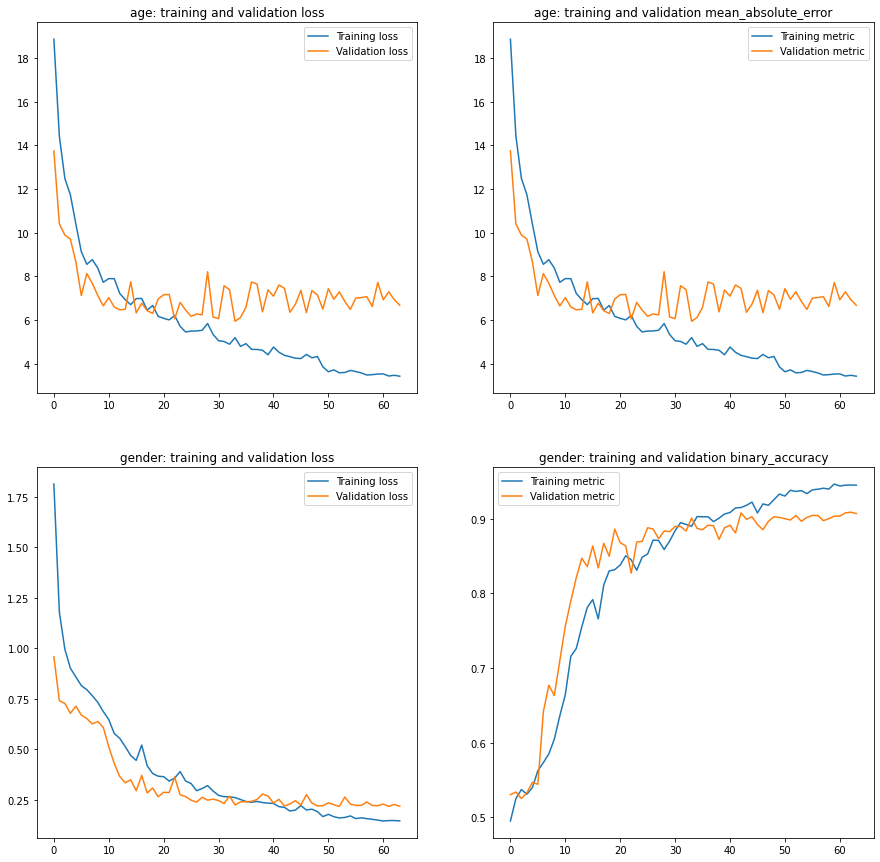

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
draw_learning_curve_loss(history_modelB, 'age')

plt.subplot(2, 2, 2)
draw_learning_curve_metric(history_modelB, 'age', 'mean_absolute_error')

plt.subplot(2, 2, 3)
draw_learning_curve_loss(history_modelB, 'gender')

plt.subplot(2, 2, 4)
draw_learning_curve_metric(history_modelB, 'gender', 'binary_accuracy')

plt.show()

We can see that modelB obtains better results than modelA. Learning curves in case of modelB are smoother, too. To conclude, we argue that fine-tuning in our case worked better than training from scratch; but, once again, there are some ways to improve quality of modelA.